In [ ]:
# ============================================
# STEP 1: Install dependencies
# ============================================
!pip install gradio xgboost -q

# ============================================
# STEP 2: Import libraries
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# ============================================
# STEP 3: Load dataset
# ============================================
url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+q1_q17_dr25_koi&format=csv"
df = pd.read_csv(url)
print("Original shape:", df.shape)
df.head()


Original shape: (8054, 153)


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


In [ ]:
# ============================================
# STEP 4: Data Cleaning, Feature Engineering & Balancing
# ============================================
from sklearn.impute import SimpleImputer
from scipy import stats
from imblearn.over_sampling import SMOTE

# ---- 1️⃣ Add More Meaningful Features ----
features = [
    "koi_period", "koi_duration", "koi_prad", "koi_depth", "koi_steff",
    "koi_srad", "koi_smass", "koi_model_snr", "koi_max_sngle_ev",
    "koi_ror", "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co",
    "koi_fpflag_ec", "koi_impact", "koi_insol"
]

# Keep only columns that exist in dataset (some may not be available)
features = [f for f in features if f in df.columns]

# Select and clean data
df = df[features + ["koi_disposition"]].copy()

# ---- 2️⃣ Handle Missing Values ----
imputer = SimpleImputer(strategy="median")
df[features] = imputer.fit_transform(df[features])

# ---- 3️⃣ Encode Labels ----
label_map = {"CONFIRMED": 0, "CANDIDATE": 1, "FALSE POSITIVE": 2}
df["label"] = df["koi_disposition"].map(label_map)

# Drop rows with missing labels
df = df.dropna(subset=["label"])

X = df[features]
y = df["label"]

print("✅ After imputation, dataset shape:", df.shape)

# ---- 4️⃣ Remove Outliers (Z-score filtering) ----
z_scores = np.abs(stats.zscore(X))
df = df[(z_scores < 3).all(axis=1)]
X = df[features]
y = df["label"]

print("✅ After removing outliers:", df.shape)

# ---- 5️⃣ Balance Classes (SMOTE) ----
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# Final output
print("✅ After SMOTE balancing:")
print(pd.Series(y_bal).value_counts())

# ---- 6️⃣ Final Data Overview ----
print(f"Final dataset size: {X_bal.shape[0]} samples, {X_bal.shape[1]} features")


✅ After imputation, dataset shape: (6980, 11)
✅ After removing outliers: (6022, 11)
✅ After SMOTE balancing:
label
2    2560
0    2560
1    2560
Name: count, dtype: int64
Final dataset size: 7680 samples, 9 features


In [ ]:
# ============================================
# STEP 5: Normalize & Split the Balanced Dataset
# ============================================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1️⃣ Initialize the scaler
scaler = StandardScaler()

# 2️⃣ Scale the balanced dataset
X_scaled = scaler.fit_transform(X_bal)

# 3️⃣ Split the balanced data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_bal,
    test_size=0.2,
    stratify=y_bal,   # ensures all classes remain balanced after split
    random_state=42
)

# 4️⃣ Display summary
print("✅ Dataset successfully scaled and split!")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Feature count:", X_train.shape[1])


✅ Dataset successfully scaled and split!
Training samples: 6144
Testing samples: 1536
Feature count: 9



🔹 Random Forest Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.82      0.82      0.82       512
     CANDIDATE       0.78      0.80      0.79       512
FALSE POSITIVE       0.81      0.79      0.80       512

      accuracy                           0.81      1536
     macro avg       0.81      0.81      0.81      1536
  weighted avg       0.81      0.81      0.81      1536



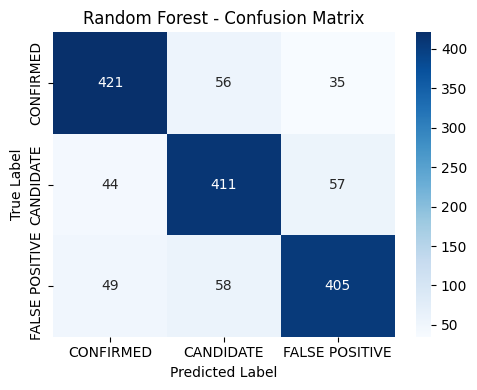


🔹 Logistic Regression Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.58      0.65      0.61       512
     CANDIDATE       0.48      0.57      0.52       512
FALSE POSITIVE       0.78      0.54      0.64       512

      accuracy                           0.59      1536
     macro avg       0.61      0.59      0.59      1536
  weighted avg       0.61      0.59      0.59      1536



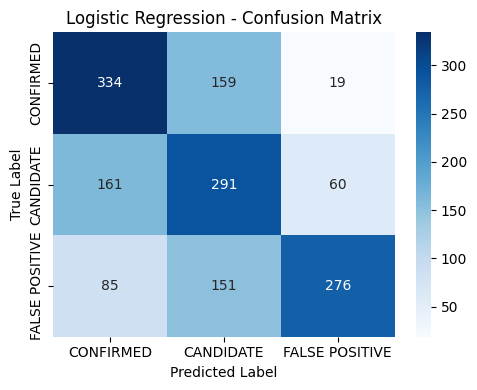


🔹 Neural Network Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.80      0.83      0.82       512
     CANDIDATE       0.73      0.75      0.74       512
FALSE POSITIVE       0.82      0.78      0.80       512

      accuracy                           0.79      1536
     macro avg       0.79      0.79      0.79      1536
  weighted avg       0.79      0.79      0.79      1536



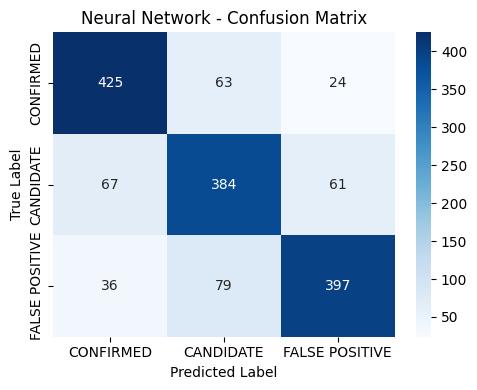


🔹 XGBoost Performance:
                precision    recall  f1-score   support

     CONFIRMED       0.83      0.83      0.83       512
     CANDIDATE       0.79      0.83      0.81       512
FALSE POSITIVE       0.86      0.82      0.84       512

      accuracy                           0.83      1536
     macro avg       0.83      0.83      0.83      1536
  weighted avg       0.83      0.83      0.83      1536



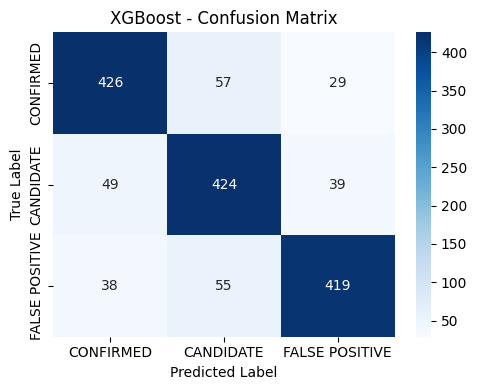


✅ Model Comparison Summary:
                 Model  Accuracy  F1-score
0              XGBoost  0.826172  0.826406
1        Random Forest  0.805339  0.805370
2       Neural Network  0.785156  0.785328
3  Logistic Regression  0.586589  0.590437


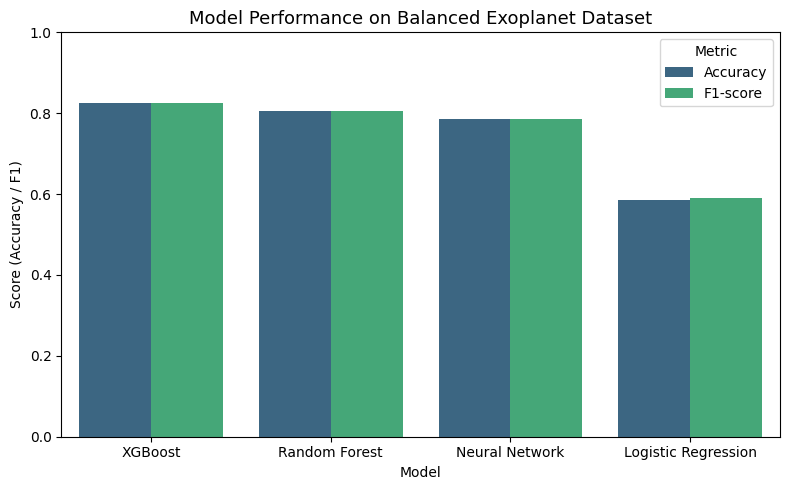

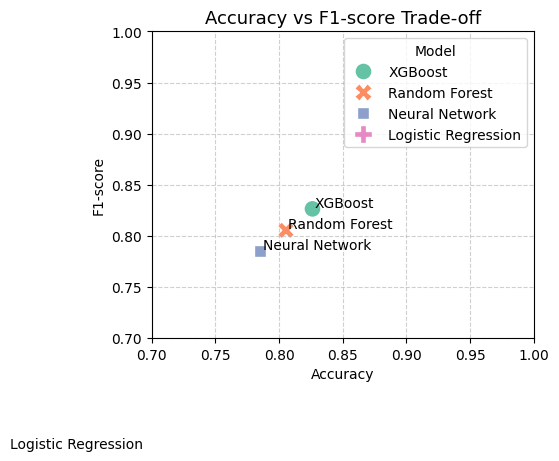

In [ ]:
# ============================================
# STEP 6: Train, Evaluate & Visualize Models
# ============================================
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Define models
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(64, 32), max_iter=500, random_state=42
    ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    ),
}

# 2️⃣ Train, evaluate & visualize each model
results = []
class_names = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")
    results.append({"Model": name, "Accuracy": acc, "F1-score": f1})

    print(f"\n🔹 {name} Performance:")
    print(classification_report(y_test, preds, target_names=class_names))

    # Confusion Matrix Visual
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    print("=" * 80)

# 3️⃣ Summary table
results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
print("\n✅ Model Comparison Summary:")
print(results_df.reset_index(drop=True))

# 4️⃣ Bar chart: Model performance
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.melt(id_vars="Model", var_name="Metric", value_name="Score"),
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)
plt.title("Model Performance on Balanced Exoplanet Dataset", fontsize=13)
plt.ylabel("Score (Accuracy / F1)")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

# 5️⃣ Scatter plot: Accuracy vs F1-score
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=results_df,
    x="Accuracy",
    y="F1-score",
    hue="Model",
    s=150,
    style="Model",
    palette="Set2"
)
for i, row in results_df.iterrows():
    plt.text(row["Accuracy"] + 0.002, row["F1-score"] + 0.002, row["Model"])
plt.title("Accuracy vs F1-score Trade-off", fontsize=13)
plt.xlabel("Accuracy")
plt.ylabel("F1-score")
plt.xlim(0.7, 1)
plt.ylim(0.7, 1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


🏆 Best Model Based on F1-score: XGBoost


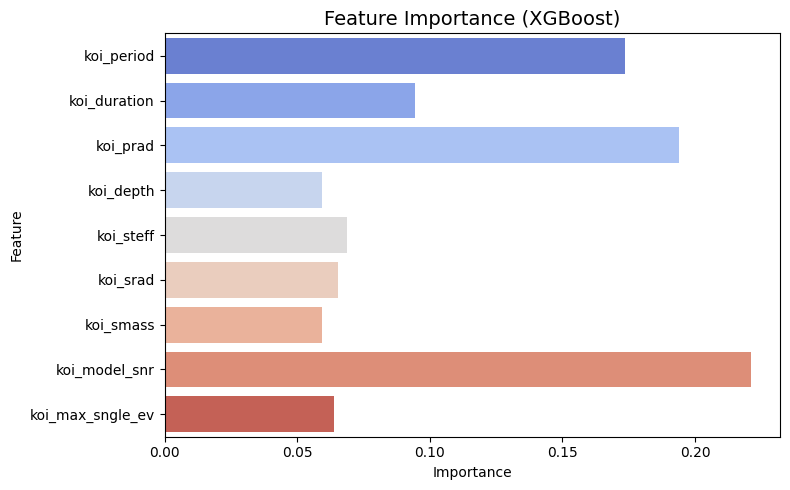

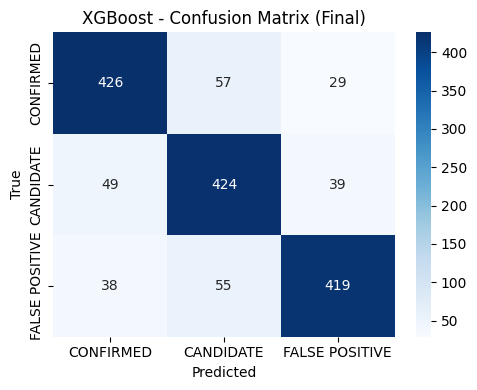

✅ Saved best model and scaler successfully as best_model_XGBoost.pkl

Model 'XGBoost' achieved Accuracy = 0.826, F1-score = 0.826


In [ ]:
# ============================================
# STEP 7: Analyze Best Model & Save for Deployment
# ============================================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1️⃣ Pick best model based on F1-score
best_model_name = results_df.iloc[0]['Model']
print(f"🏆 Best Model Based on F1-score: {best_model_name}")

best_model = models[best_model_name]

# 2️⃣ Feature importance (for tree-based models)
if best_model_name in ["XGBoost", "Random Forest"]:
    importances = best_model.feature_importances_

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=importances,
        y=features,
        palette="coolwarm"
    )
    plt.title(f"Feature Importance ({best_model_name})", fontsize=14)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ {best_model_name} doesn’t support feature importance directly.")

# 3️⃣ Confusion Matrix for the Best Model
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title(f"{best_model_name} - Confusion Matrix (Final)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 4️⃣ Save model and scaler
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
joblib.dump(scaler, "scaler.pkl")
print(f"✅ Saved best model and scaler successfully as best_model_{best_model_name}.pkl")

# 5️⃣ Optional: quick summary line
print(f"\nModel '{best_model_name}' achieved Accuracy = "
      f"{results_df.iloc[0]['Accuracy']:.3f}, F1-score = {results_df.iloc[0]['F1-score']:.3f}")


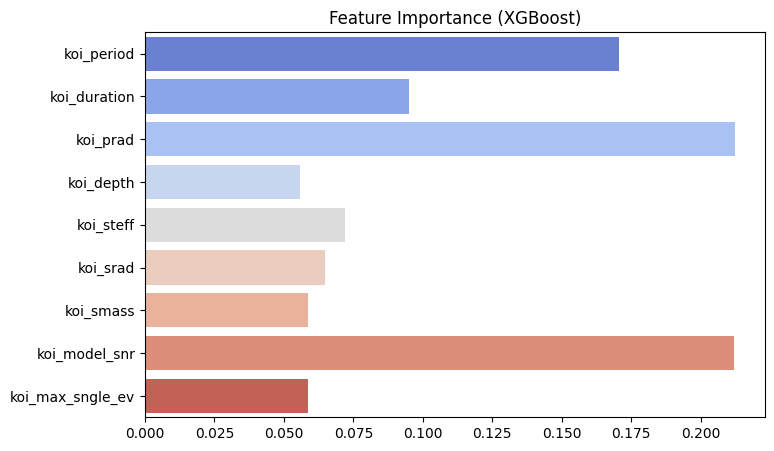

In [ ]:
# ============================================
# STEP 7: Feature Importance (for tree models)
# ============================================
best_model = models["XGBoost"]
importances = best_model.feature_importances_

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features, palette="coolwarm")
plt.title("Feature Importance (XGBoost)")
plt.show()


In [ ]:
# ============================================
# STEP 8: Save Best Model (XGBoost) for Gradio
# ============================================
import joblib

joblib.dump(best_model, "best_exoplanet_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!
